In [260]:
!pip install indic-nlp-library

In [261]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [262]:
import matplotlib.pyplot as plt

import torch
from torch import nn,tensor
from torch.utils.data import Dataset,DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
import re
import numpy as np
import pandas as pd
import pickle
from indicnlp.tokenize import indic_tokenize
import seaborn as sns

train_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/midas_discourse/midas/train.json'
test_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/midas_discourse/midas/test.json'
# val_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/movie_reviews/hi/hi-valid.csv'
forward_model_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/pretrained_forward_model'
backward_model_path ='/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/pretrained_backward_model'
word_to_ix_path = '/content/drive/MyDrive/Colab Notebooks/INLP Project/train embeddings/word_to_ix.pkl'

In [263]:
import pandas as pd
import json


with open(train_path, 'r', encoding='utf-8') as json_file:
    train = json.load(json_file)


train_df = [{"Label": entry["Discourse Mode"], "Text": entry["Sentence"]} for entry in train]

train_df = pd.DataFrame(train_df)
train_df = train_df[train_df['Label'] != 'Other']
train_df.head()


,Label,Text
0,Narrative,पाँच साल गुजर गये।
1,Narrative,बिरजू के माँ ने आँगन से निकल गाँव की ओर कान ल...
2,Descriptive,"कुछ लोग घर वाले होते हैं, कुछ लोग सीढ़ीयों के ..."
3,Narrative,राम खिलावन ने अपनी कोठरी में जाकर अन्दर से दरव...
4,Dialogue,इन्होंने कहा' शहर कोतवाल का अधिकार पूर्ण शब्द...


In [264]:
with open(test_path, 'r', encoding='utf-8') as json_file:
    test = json.load(json_file)


test_df = [{"Label": entry["Discourse Mode"], "Text": entry["Sentence"]} for entry in test]

test_df = pd.DataFrame(test_df)
test_df = test_df[test_df['Label'] != 'Other']

test_df.head()


,Label,Text
0,Narrative,एक कबूतर पंख फडफ़ड़ाता हुआ कहवाख़ाने के अन्दर ...
1,Descriptive,हर महीने दस दस के पाँच नोट वो अपने ख़फ़ीफ़ तौर पर...
2,Dialogue,आख़िर शरीफ़ ख़ान-दान से तअल्लुक़ है ”
3,Descriptive,दूसरे हो दिन से उस अमराई में रोज ही कुछ आदमी र...
4,Narrative,नक़लों के और नक़लों की नक़लों के पहाड़ लग गये।


In [265]:
# df.to_csv('output.csv', index=False)


In [266]:

# train_df = pd.read_csv(train_path, header=None, names=['Label', 'Text'])

# test_df = pd.read_csv(test_path, header=None, names=['Label', 'Text'])
# train_df.head()



In [267]:
train_df.Label.value_counts()

Label
Descriptive      2912
Narrative        2489
Dialogue         2361
Argumentative     105
Informative        67
Name: count, dtype: int64

In [268]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])
test_df.head()


,Label,Text
0,4,एक कबूतर पंख फडफ़ड़ाता हुआ कहवाख़ाने के अन्दर ...
1,1,हर महीने दस दस के पाँच नोट वो अपने ख़फ़ीफ़ तौर पर...
2,2,आख़िर शरीफ़ ख़ान-दान से तअल्लुक़ है ”
3,1,दूसरे हो दिन से उस अमराई में रोज ही कुछ आदमी र...
4,4,नक़लों के और नक़लों की नक़लों के पहाड़ लग गये।


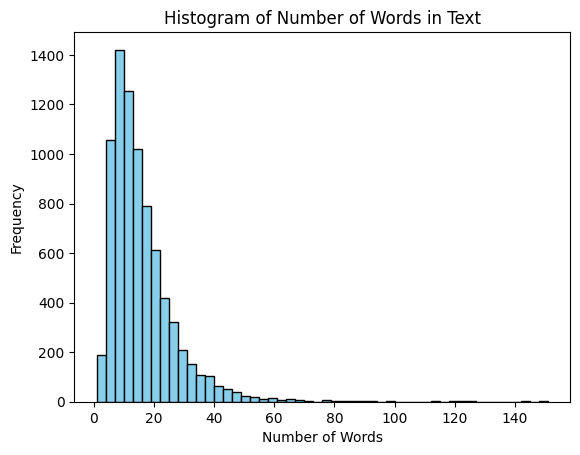

In [269]:

text_word_counts = train_df['Text'].apply(lambda x: len(x.split()))

plt.hist(text_word_counts, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Words in Text')
plt.show()


In [270]:
class ElmoProcessor(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,wt_mat):
        super(ElmoProcessor,self).__init__()
        #self.embeddings=nn.Embedding(vocab_size,embedding_dim)
        self.lstmf1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmf2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        self.embedding=wt_mat.to(device)
        # self.lstmb1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        # self.lstmb2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)

        self.linear=nn.Linear(hidden_dim,vocab_size)
    def forward(self,embeddingdata):
        emb=torch.tensor(self.embedding(embeddingdata.to(device)))

        emb_f=emb
        # emb_b=emb.flip(1)

        o1f1,h1f1=self.lstmf1(emb_f)
        o2f2,h2f2=self.lstmf2(o1f1)
        # o2f2=o2f2+o1f1
        # h2f2=h2f2+h1f1
        # o1b1,h1b1=self.lstmb1(emb_b)
        # o2b2,h2b2=self.lstmb2(o1b1,h1b1)
        # o2b2=o2b2+o1b1
        # h2b2=h2b2+h1b1

        # weighted_vector_emb=torch.cat([emb_f,emb_b],dim=2)
        # weighted_vector_h1=torch.cat([o1f1,o1f1],dim=2)
        # weighted_vector_h2=torch.cat([o1f1,o2f2],dim=2)
        output =self.linear(o2f2)
        return (output,o1f1,o2f2)

In [271]:
device = "cuda" if torch.cuda.is_available() else "cpu"

wt_mat=torch.zeros(size=(90337,300))
embeddings=torch.tensor(wt_mat,dtype=torch.float)
forward_model= torch.load(forward_model_path,map_location=torch.device('cpu'))
backward_model= torch.load(backward_model_path,map_location=torch.device('cpu'))

<ipython-input-271-b61a903641ab>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings=torch.tensor(wt_mat,dtype=torch.float)


In [272]:
with open(word_to_ix_path, 'rb') as file:

    word_to_ix = pickle.load(file)


In [273]:
mxlen=[]
for column in train_df[train_df.columns[1]]:
    mxlen.append(len(column.split(' ')))
max(mxlen)

152

In [274]:

mxlen = 15
class DatafetchClassify(Dataset):
    def __init__(self,split:str):
        sequence=[]
        labels=[]
        for x in tqdm(split[split.columns[1]],desc='Generate next word prediction data'):
            if len(x)<2 or x[0]=='=':continue
            words=indic_tokenize.trivial_tokenize(x,'hi') # alternative: x.strip().split(' ')
            words=words
            indices=[word_to_ix.get(word, 1) for word in words[:mxlen]]
            sequence.append((mxlen-len(indices))*[word_to_ix['<PAD>']]+indices[:])
        for x in tqdm(split[split.columns[0]],desc="Generate label"):
            labels.append(x)
        max_seq_len=max([len(ngram) for ngram in sequence])
        self.sequence=tensor(sequence)
        self.sequence.to(device)
        self.labels=tensor(labels)
        self.labels.to(device)
    def __len__(self)->int:
        return len(self.sequence)
    def __getitem__(self,index:int):
        return self.sequence[index],self.labels[index]

In [275]:
classifier_dataset=DatafetchClassify(train_df)

Generate label: 100%|██████████| 7934/7934 [00:00<00:00, 1326805.47it/s]


In [276]:
batch_size=256

In [277]:
classifer_dataloader=DataLoader(classifier_dataset,batch_size,shuffle=True)
data,labels=next(iter(classifer_dataloader))


In [278]:
class ElmoClassifier(torch.nn.Module):
    def __init__(self,no_classes,forward_model,backward_model,embedding_dim):
        super(ElmoClassifier,self).__init__()
        self.forward_model=forward_model
        self.embedding = forward_model.embedding
        self.backward_model=backward_model
        self.forward_model.requires_grad=False
        self.backward_model.requires_grad=False
        self.linear1=nn.Linear(100,no_classes)
        self.param0=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param1=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param2=nn.Parameter(torch.rand(1),requires_grad=True)
        self.bilstm=nn.LSTM(input_size=embedding_dim*2,hidden_size=50,bidirectional=True,batch_first=True)
    def forward(self,embdata):
        _,o1f1,o2f2=self.forward_model(embdata)
        _,o1b1,o2b2=self.backward_model(embdata)
        # print(embdata.shape)
        # print('\n',o1f1.shape)
        embdata = self.embedding(embdata)
        e = torch.cat([embdata, embdata.flip(1)],dim=2)
        h1=torch.cat([o1f1,o1b1.flip(1)],dim=2)
        h2=torch.cat([o2f2,o2b2.flip(1)],dim=2)
        bio,bih=self.bilstm(self.param0*e + self.param1*h1 +self.param2*h2)

        y=self.linear1(bio[:,-1,:])

        return y

In [279]:
classifier=ElmoClassifier(5,forward_model,backward_model,300)

In [280]:
classifier.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(classifier.parameters(),1e-3)

In [281]:
for epoch in range(5):
    train_loss=0
    classifier.train()
    for batch in tqdm(classifer_dataloader,desc="Training"):
        x_train,y_train=batch
        optimizer.zero_grad()

        x_train.to(device)
        y_train.to(device)
        output=classifier(x_train)
        loss=loss_fn(output.to(device),y_train.to(device))
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)

Training:   0%|          | 0/31 [00:00<?, ?it/s]<ipython-input-270-b766623ffbb4>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Training: 100%|██████████| 31/31 [06:45<00:00, 13.09s/it]


38.78493523597717


Training: 100%|██████████| 31/31 [06:13<00:00, 12.05s/it]


35.66918480396271


Training: 100%|██████████| 31/31 [06:22<00:00, 12.33s/it]


33.938769578933716


Training: 100%|██████████| 31/31 [06:24<00:00, 12.39s/it]


32.11682265996933


Training: 100%|██████████| 31/31 [06:19<00:00, 12.24s/it]

30.018283665180206


In [282]:
classifier_eval=DatafetchClassify(test_df)

Generate label: 100%|██████████| 991/991 [00:00<00:00, 967766.07it/s]


In [283]:
classifer_dataloader_eval=DataLoader(classifier_eval,batch_size=64,shuffle=False)
data,labels=next(iter(classifer_dataloader_eval))


In [284]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix=np.zeros((4,4))
y_true=[]
y_pred=[]
train_loss=0.0
for batch in tqdm(classifer_dataloader_eval,desc="Evaluation"):
    x_train,y_train=batch
    optimizer.zero_grad()

    x_train.to(device)
    y_train.to(device)
    output=classifier(x_train)
    _,preds=torch.max(output,dim=1)
    y_true.extend(y_train.cpu().detach().numpy())
    y_pred.extend(preds.cpu().detach().numpy())

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-270-b766623ffbb4>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb=torch.tensor(self.embedding(embeddingdata.to(device)))
Evaluation: 100%|██████████| 16/16 [00:43<00:00,  2.70s/it]


In [285]:
accuracy_score(y_true,y_pred)

0.6881937436932392

In [286]:
torch.save(classifier,'/content/drive/MyDrive/Colab Notebooks/INLP Project/midas_discourse/discourse_classifier')

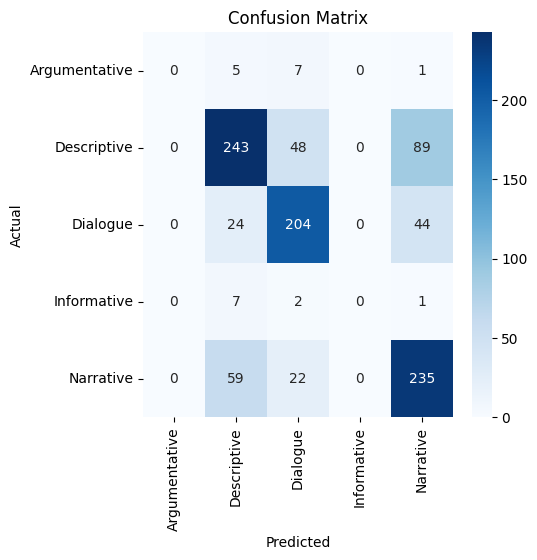

In [287]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predicted_classes = label_encoder.inverse_transform(y_pred)
true_classes = label_encoder.inverse_transform(y_true)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [288]:
from sklearn.metrics import classification_report

target_names = label_encoder.classes_
print(classification_report(y_true, y_pred, target_names=target_names))

               precision    recall  f1-score   support

Argumentative       0.00      0.00      0.00        13
  Descriptive       0.72      0.64      0.68       380
     Dialogue       0.72      0.75      0.74       272
  Informative       0.00      0.00      0.00        10
    Narrative       0.64      0.74      0.69       316

     accuracy                           0.69       991
    macro avg       0.41      0.43      0.42       991
 weighted avg       0.68      0.69      0.68       991



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [289]:
# print(md5)

In [290]:
# print(classifier)